In [11]:
import os
from google.cloud import vision
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.transform import rotate, resize, rescale
import ultralytics
from ultralytics import YOLO
from concurrent.futures import ThreadPoolExecutor
ultralytics.checks()

# Our scripts
from Python_Helpers.image_loading import * 
from Python_Helpers.preprocessing import * 
from Python_Helpers.corrections import *
from Python_Helpers.ID_isolation import *
from Python_Helpers.YOLO import *
from Python_Helpers.analysis import *

# YOLO stuff.
character_mapping = {0:'0',1:'1',12:'2',14:'3',15:'4',16:'5',17:'6',18:'7',19:'8',20:'B',
                    2:'F',3:'G',4:'K',5:'N',6:'O',7:'P',8:'R',9:'S',10:'V',11:'W',13:'Y', 21:''}
model = YOLO(r'YOLO_Data/best.pt')

# # Google cloud files (authenticate using SDK).
# google_file_list = ListGoogleFiles('guppy_images', prefix='Manually_Labelled/New', verbose=True)
# random.shuffle(google_file_list)

# # Dropbox authentication enter details into the Dropbox_token.json file.
import dropbox
DropboxDict = LoadDropboxDetails('/Users/jordanlee/Projects/Guppies_User/Dropbox_token.json')
dbx = dropbox.Dropbox(
            app_key = DropboxDict['app_key'],
            app_secret = DropboxDict['app_secret'],
            oauth2_refresh_token = DropboxDict['oauth2_refresh_token']
)
dropbox_file_list = ListDropBoxFiles(dbx, '', prefix='Guppy_Images', suffix='', verbose=True)

Ultralytics YOLOv8.0.228 🚀 Python-3.11.5 torch-2.1.2 CPU (Apple M2 Pro)
Setup complete ✅ (10 CPUs, 16.0 GB RAM, 94.1/460.4 GB disk)

Files have been read from Dropbox.


In [12]:
len(dropbox_file_list), dropbox_file_list

(90,
 ['/Guppy_Images/Test_Folder/FCA1B4W1212.JPG',
  '/Guppy_Images/Test_Folder/MTY3P5P1207.JPG',
  '/Guppy_Images/Test_Folder/MTY2V5G1207.JPG',
  '/Guppy_Images/Test_Folder/MTY2V5R1207.JPG',
  '/Guppy_Images/Test_Folder/MTY2W4S1207.JPG',
  '/Guppy_Images/Test_Folder/MTY2W6B1207.JPG',
  '/Guppy_Images/Test_Folder/MTY2V4S1207.JPG',
  '/Guppy_Images/Test_Folder/MTY2W8S1207.JPG',
  '/Guppy_Images/Test_Folder/MTY2Y3G1207.JPG',
  '/Guppy_Images/Test_Folder/MTY2Y5G1207.JPG',
  '/Guppy_Images/Test_Folder/MTY2Y5V1207.JPG',
  '/Guppy_Images/Test_Folder/MTY2Y8O1207.JPG',
  '/Guppy_Images/Test_Folder/MTY3B5K1207.JPG',
  '/Guppy_Images/Test_Folder/MTY3B5P1207.JPG',
  '/Guppy_Images/Test_Folder/MTY3B6K1207.JPG',
  '/Guppy_Images/Test_Folder/MTY3B7G1207.JPG',
  '/Guppy_Images/Test_Folder/MTY3B8Y1207.JPG',
  '/Guppy_Images/Test_Folder/MTY3B7S1207.JPG',
  '/Guppy_Images/Test_Folder/MTY3F4S1207.JPG',
  '/Guppy_Images/Test_Folder/MTY3G4V1207.JPG',
  '/Guppy_Images/Test_Folder/MTY3G7S1207.JPG',
  '/Gupp

In [13]:
# Runs an image file through the whole code and outputs three predictions (google, YOLO and final) along with the initial and ID images.
def MainFunction(image_in_bytes, padx=80, pady=20, delta_width=10, probability_threshold=0.5, verbose=False):
    # Initial google read and preprocessing of image.
    decoded = np.frombuffer(image_in_bytes.getvalue(), dtype=np.uint8)
    initial_image = cv2.imdecode(decoded, cv2.IMREAD_COLOR)

    if verbose: plt.imshow(initial_image)

    Initial_Results = GoogleRead(image_in_bytes, verbose=verbose)
    Processed_Results, title, ID, date = PreprocessLabel(Initial_Results, verbose=verbose)

    # Corrected google prediction.
    title, google_ID, date = CorrectOutput(title, ID, date)

    # Identity isolation and YOLO ID results
    ID_Dictionary = IsolateIdentity(Processed_Results, padx=padx, pady=pady, delta_width=delta_width, activate_validity_test=False, verbose=verbose)
    characters, boxes, probs, processed_ID_image = UseYOLO(model, ID_Dictionary['frame'], character_mapping, probability_threshold=probability_threshold, verbose=verbose)
    YOLO_ID = ''.join(characters)

    final_ID = DecideID(YOLO_ID, google_ID, verbose=verbose)

    if verbose:
        print('\nGoogle prediction:', '-'.join([title, google_ID, date]))
        print('YOLO prediction:', '-'.join([title, YOLO_ID, date]))
        print('Final prediction:', '-'.join([title, final_ID, date]))

        plt.imshow(ID_Dictionary['frame'])

    return '-'.join([title, google_ID, date]), '-'.join([title, YOLO_ID, date]), '-'.join([title, final_ID, date]), initial_image, ID_Dictionary['frame'], processed_ID_image

Corrupt JPEG data: premature end of data segment



image 1/1 /Users/jordanlee/Projects/Guppies_User/xlkaxlbkfv.jpg: 64x256 1 13, 1 16, 1 19, 1 2, 1 5, 11.8ms
Speed: 0.3ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 256)


#######################
Google Prediction: MTY-2V5R-07/25/12
YOLO Prediction: MTY-25R-07/25/12
Final Prediction: MTY-2V5R-07/25/12
#######################


Text(0.5, 1.0, 'Final ID')

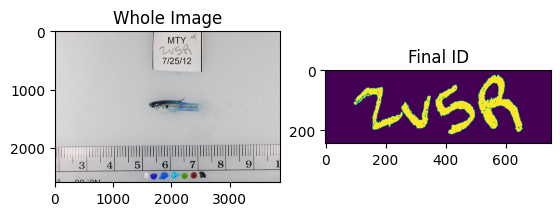

In [14]:
# Load from google
# file_name = random.choice(google_file_list)
# file_name = 'Manually_Labelled/New/CA1206/FCA1B4B1206.JPG'
# image_in_bytes = RetreiveImageGoogle('guppy_images', file_name)

# Load from Dropbox
# file_name = random.choice(dropbox_file_list)
file_name = dropbox_file_list[3]
image_in_bytes = RetreiveImageDropBox(dbx, file_name)

# # Load from local file
# file_name = "path/to/Guppy/image.JPG"
# image_in_bytes = RetreiveImageLocal(file_name)

try:
    Google_Prediction, YOLO_Prediction, Final_Prediction, initial_image, ID_image, processed_ID_image = MainFunction(image_in_bytes, probability_threshold=0.5, verbose=False)

except Exception as e: print('Error. Failed to make prediction. \
                             \nDiagnosis:', e)


print('\n\n#######################')
print('Google Prediction:', Google_Prediction)
print('YOLO Prediction:', YOLO_Prediction)
print('Final Prediction:', Final_Prediction)
print('#######################')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(initial_image)
ax2.imshow(ID_image)

ax1.set_title('Whole Image')
ax2.set_title('Final ID')